In [3]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import *
drive.mount('/content/drive')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#reading data file
data = pd.read_csv('/content/drive/MyDrive/file.csv')
label_map = {'bad': 0, 'neutral': 1, 'good': 2}

data['labels'] = data['labels'].map(label_map)

In [5]:
print(data)

        Unnamed: 0                                             tweets  labels
0                0  ChatGPT: Optimizing Language Models for Dialog...       1
1                1  Try talking with ChatGPT, our new AI system wh...       2
2                2  ChatGPT: Optimizing Language Models for Dialog...       1
3                3  THRILLED to share that ChatGPT, our new model ...       2
4                4  As of 2 minutes ago, @OpenAI released their ne...       0
...            ...                                                ...     ...
219289      219289  Other Software Projects Are Now Trying to Repl...       0
219290      219290  I asked #ChatGPT to write a #NYE Joke for SEOs...       2
219291      219291  chatgpt is being disassembled until it can onl...       0
219292      219292  2023 predictions by #chatGPT. Nothing really s...       0
219293      219293   From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0       1

[219294 rows x 3 columns]


In [6]:
x = data['tweets']
y = data['labels']
print(x)
print('/////////////////////')
print(y)

0         ChatGPT: Optimizing Language Models for Dialog...
1         Try talking with ChatGPT, our new AI system wh...
2         ChatGPT: Optimizing Language Models for Dialog...
3         THRILLED to share that ChatGPT, our new model ...
4         As of 2 minutes ago, @OpenAI released their ne...
                                ...                        
219289    Other Software Projects Are Now Trying to Repl...
219290    I asked #ChatGPT to write a #NYE Joke for SEOs...
219291    chatgpt is being disassembled until it can onl...
219292    2023 predictions by #chatGPT. Nothing really s...
219293     From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0
Name: tweets, Length: 219294, dtype: object
/////////////////////
0         1
1         2
2         1
3         2
4         0
         ..
219289    0
219290    2
219291    0
219292    0
219293    1
Name: labels, Length: 219294, dtype: int64


In [7]:
for key, ID in label_map.items():
  print(key, ID)

bad 0
neutral 1
good 2


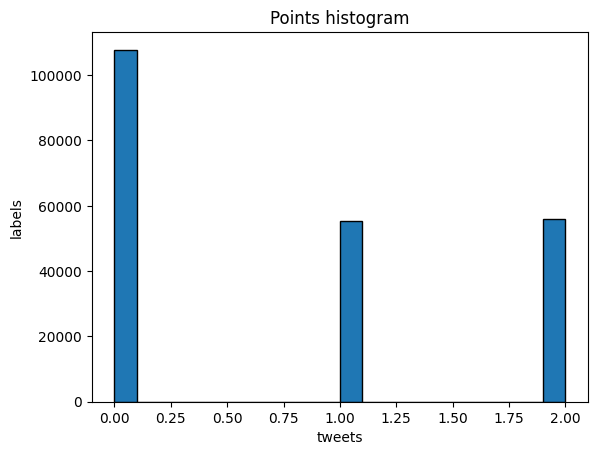

In [8]:
plt.hist(data['labels'], edgecolor='black',bins=20)
plt.title("Points histogram")
plt.ylabel("labels")
plt.xlabel("tweets")
plt.show()

In [9]:
#tokenization & padding
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index # the dictionary
print('Found %s unique tokens.' % len(word_index)) #only top MAX_NUM_WORDS will be used to generate the sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 284178 unique tokens.


In [10]:
labels_matrix = to_categorical(np.asarray(y))

In [11]:
x_train, x_val, y_train, y_val = train_test_split(data, labels_matrix, test_size=0.2, stratify=labels_matrix)
print('Shape of training data:', x_train.shape)
print('Shape of validation data:', x_val.shape)

Shape of training data: (175435, 1000)
Shape of validation data: (43859, 1000)


In [12]:
VALIDATION_SPLIT = 0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data_shuffled = data[indices]
labels_shuffled = labels_matrix[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data_shuffled.shape[0])
x_train = data_shuffled[:-nb_validation_samples]
y_train = labels_shuffled[:-nb_validation_samples]
x_val = data_shuffled[-nb_validation_samples:]
y_val = labels_shuffled[-nb_validation_samples:]
print('Shape of training data: ',x_train.shape)
print('Shape of testing data: ',x_val.shape)

Shape of training data:  (175436, 1000)
Shape of testing data:  (43858, 1000)


In [13]:
EMBEDDING_DIM = 100
print('Indexing word vectors.')
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split(sep=' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [14]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
#+1 to include the zerors vector for non-existing words
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
print ('Shape of Embedding Matrix: ',embedding_matrix.shape)

Shape of Embedding Matrix:  (284179, 100)


In [15]:
model_1 = Sequential()
model_1.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,))
model_1.add(layers.Dropout(0.5))
model_1.add(Conv1D(16,3, activation='relu'))
model_1.add(MaxPooling1D())
model_1.add(Conv1D(16,3, activation='relu'))
model_1.add(MaxPooling1D())
model_1.add(layers.Flatten())


In [16]:
var = 0
acc = []
for i in range(0,4):
  if(i == 0):
    var = 128
  elif(i == 1):
    var = 256
  elif(i == 2):
    var = 512
  else:
    var = 1024
  model_1.add(layers.Dense(var, activation='relu'))
  model_1.add(layers.Dropout(0.5))
  model_1.add(layers.Dense(3, activation='sigmoid'))
  model_1.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['acc'])

  history = model_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)
  print('Acuracy on testing set:', i)
  accuracyVar = model_1.evaluate(x_val,y_val)
  acc.append(accuracyVar)
print(acc)

Epoch 1/5
1371/1371 [==============================] - 73s 46ms/step - loss: 0.8216 - acc: 0.6311 - val_loss: 0.6214 - val_acc: 0.7495
Epoch 2/5
1371/1371 [==============================] - 27s 19ms/step - loss: 0.6160 - acc: 0.7543 - val_loss: 0.4972 - val_acc: 0.8148
Epoch 3/5
1371/1371 [==============================] - 26s 19ms/step - loss: 0.5374 - acc: 0.7950 - val_loss: 0.4490 - val_acc: 0.8417
Epoch 4/5
1371/1371 [==============================] - 24s 17ms/step - loss: 0.4916 - acc: 0.8195 - val_loss: 0.4113 - val_acc: 0.8574
Epoch 5/5
1371/1371 [==============================] - 24s 17ms/step - loss: 0.4636 - acc: 0.8336 - val_loss: 0.4209 - val_acc: 0.8558
Acuracy on testing set: 0
1371/1371 [==============================] - 5s 4ms/step - loss: 0.4209 - acc: 0.8558
Epoch 1/5
1371/1371 [==============================] - 54s 38ms/step - loss: 0.4622 - acc: 0.8366 - val_loss: 0.3777 - val_acc: 0.8689
Epoch 2/5
1371/1371 [==============================] - 27s 20ms/step - loss: 0

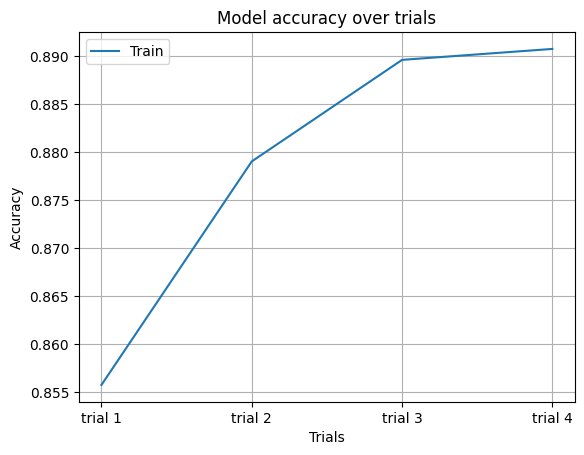

In [17]:
# Plot accuracy vs trials
accList = []
for i in acc:
  accList.append(i[1])
x = range(len(accList))
plt.plot(x, accList)
custom_labels = ['trial 1', 'trial 2', 'trial 3', 'trial 4']
plt.xticks(x, custom_labels)
plt.title('Model accuracy over trials')
plt.ylabel('Accuracy')
plt.xlabel('Trials')
plt.legend(['Train'], loc='upper left')
plt.grid(True)
plt.show()

In [18]:
def prediction(model,tweet):
  sequences_ = tokenizer.texts_to_sequences(tweet)
  data_p = pad_sequences(sequences_, maxlen=MAX_SEQUENCE_LENGTH)
  label_vec = model.predict(data_p) 
  label_num = np.argmax(label_vec)
  label_type = ""
  if(label_num == 0):
    label_type = "bad"
  elif(label_num == 1):
    label_type = "neutral"
  else:
    label_type = "good"
  return tweet , label_type

In [19]:
inputuser = input("enter a sentence: ")
tweet, labeltype = prediction(model_1,[inputuser])
print(tweet)
print(labeltype)

enter a sentence: chat gpt is useful and helpful and replying fast on our questions
1/1 [==============================] - 0s 231ms/step
['chat gpt is useful and helpful and replying fast on our questions']
good


In [20]:

model_2 = Sequential()
model_2.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,))
model_2.add(layers.Dropout(0.5))
model_2.add(LSTM(16, return_sequences=True))
model_2.add(layers.Dropout(0.5))
model_2.add(LSTM(16))
model_2.add(layers.Dropout(0.5))

In [21]:
var2 = 0
accuracies = []
for i in range(0,4):
  if(i == 0):
    var2 = 128
  elif(i == 1):
    var2 = 256
  elif(i == 2):
    var = 512
  else:
    var2 = 1024
  model_2.add(layers.Dense(var2, activation='relu'))
  model_2.add(layers.Dropout(0.5))
  model_2.add(layers.Dense(3, activation='sigmoid'))
  model_2.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['acc'])
  history = model_2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)
  print('Acuracy on testing set:', i)
  accuracyVar = model_2.evaluate(x_val,y_val)
  accuracies.append(accuracyVar)
print(accuracies)

Epoch 1/5
1371/1371 [==============================] - 115s 80ms/step - loss: 0.8326 - acc: 0.6212 - val_loss: 0.5797 - val_acc: 0.7526
Epoch 2/5
1371/1371 [==============================] - 102s 74ms/step - loss: 0.6123 - acc: 0.7468 - val_loss: 0.4636 - val_acc: 0.8307
Epoch 3/5
1371/1371 [==============================] - 80s 58ms/step - loss: 0.5178 - acc: 0.7993 - val_loss: 0.3905 - val_acc: 0.8604
Epoch 4/5
1371/1371 [==============================] - 79s 58ms/step - loss: 0.4616 - acc: 0.8276 - val_loss: 0.3449 - val_acc: 0.8775
Epoch 5/5
1371/1371 [==============================] - 82s 60ms/step - loss: 0.4197 - acc: 0.8465 - val_loss: 0.3215 - val_acc: 0.8876
Acuracy on testing set: 0
1371/1371 [==============================] - 29s 21ms/step - loss: 0.3215 - acc: 0.8876
Epoch 1/5
1371/1371 [==============================] - 109s 77ms/step - loss: 0.4064 - acc: 0.8581 - val_loss: 0.3022 - val_acc: 0.8965
Epoch 2/5
1371/1371 [==============================] - 86s 63ms/step - lo

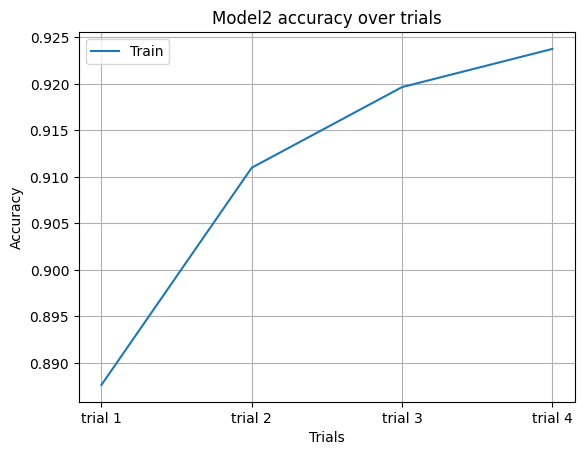

In [22]:
# Plot accuracy vs trials
accList2 = []
for i in accuracies:
  accList2.append(i[1])
x = range(len(accList2))
plt.plot(x, accList2)
custom_labels = ['trial 1', 'trial 2', 'trial 3', 'trial 4']
plt.xticks(x, custom_labels)
plt.title('Model2 accuracy over trials')
plt.ylabel('Accuracy')
plt.xlabel('Trials')
plt.legend(['Train'], loc='upper left')
plt.grid(True)
plt.show()

In [23]:
inputuser = input("enter a sentence: ")
tweet, labeltype = prediction(model_2,[inputuser])
print(tweet)
print(labeltype)

enter a sentence: ChatGPT is an advanced language model developed by OpenAI, designed to provide helpful and informative responses to a wide range of inquiries and conversations
1/1 [==============================] - 1s 717ms/step
['ChatGPT is an advanced language model developed by OpenAI, designed to provide helpful and informative responses to a wide range of inquiries and conversations']
good
